# Cargando y limpiando datos

Cargamos el dataset, y lo copiamos a otra variable `gen` para no perderlo

In [484]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

PATH = 'datasets/dataset_generacion_resid.csv'

data = pd.read_csv(PATH)
data.head(24)

,YEAR,MO,DY,HR,T2M,RH2M,ALLSKY_KT,ALLSKY_SFC_SW_DWN,PRECTOTCORR,WS10M,SZA,Energy PV system (Wh)
0,2022,1,26,0,7.49,91.54,-999.00,0.00,0.0,3.13,90.00,0
1,2022,1,26,1,7.39,90.57,-999.00,0.00,0.0,3.14,90.00,0
2,2022,1,26,2,7.31,88.36,-999.00,0.00,0.0,3.16,90.00,0
3,2022,1,26,3,7.33,84.90,-999.00,0.00,0.0,3.21,90.00,0
4,2022,1,26,4,7.49,80.21,-999.00,0.00,0.0,3.21,90.00,0
5,2022,1,26,5,7.80,74.86,-999.00,0.00,0.0,3.11,90.00,0
6,2022,1,26,6,8.11,69.57,-999.00,0.00,0.0,2.89,90.00,0
7,2022,1,26,7,8.57,65.11,0.33,25.27,0.0,2.55,86.85,1
8,2022,1,26,8,10.28,62.82,0.56,168.05,0.0,2.14,77.74,0
9,2022,1,26,9,11.90,51.43,0.69,333.60,0.0,1.94,69.85,0


In [454]:
gen = data.copy()
gen['Energy PV system (kWh)'] = data['Energy PV system (Wh)'] / 1000
gen.drop(columns=['Energy PV system (Wh)'], inplace=True)


In [455]:
gen = gen[(gen['SZA'] < 90) & (gen['ALLSKY_KT'] != -999)]

In [456]:
q1 = gen['Energy PV system (kWh)'].quantile(0.25)
q3 = gen['Energy PV system (kWh)'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

gen = gen[(gen['Energy PV system (kWh)'] >= lower_bound) & (gen['Energy PV system (kWh)'] <= upper_bound)]

## *Feature Engineering*

### *Features* temporales

Añadimos el **día del año** en versión fraccionaria

In [457]:
gen_temp = gen.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'})
gen['date'] = pd.to_datetime(gen_temp[['year', 'month', 'day', 'hour']])
gen['DOY'] = gen['date'].dt.dayofyear + gen['HR'] / 24.0
gen = gen.drop(columns=['date', 'YEAR'])

Añadimos el **tiempo en seno y coseno** para ver ciclos diarios

In [458]:
gen['hour_sin'] = np.sin(2 * np.pi * gen['HR'] / 24.0)

### *Features* físicas

Variables combinadas de irradiancia

In [459]:
gen['temp_irr'] = gen['T2M'] * gen['ALLSKY_SFC_SW_DWN']
gen['hum_irr'] = gen['RH2M'] * gen['ALLSKY_SFC_SW_DWN']
gen['irr_div_temp'] = gen['ALLSKY_SFC_SW_DWN'] / (gen['T2M'] + 1e-6)

Variables del ángulo del sol

In [ ]:
gen['SZA_rad'] = np.radians(gen['SZA'])
gen['SZA_sin'] = np.sin(gen['SZA_rad'])
gen['SZA_cos'] = np.cos(gen['SZA_rad'])

gen['solar_potential'] = gen['ALLSKY_SFC_SW_DWN'] * gen['SZA_cos']
gen['irradiance_to_angle'] = gen['ALLSKY_SFC_SW_DWN'] / (gen['SZA'] + 1e-6)
gen['angle_radiation'] = gen['SZA_cos'] * gen['ALLSKY_SFC_SW_DWN']

In [461]:
gen = gen.drop(columns=['MO', 'DY', 'SZA', 'SZA_rad', 'SZA_cos', 'SZA_sin'])

# Dividiendo el *dataset* usando `train_test_split`

In [462]:
X_train, X_test = train_test_split(gen, test_size=0.2, random_state=42, shuffle=False)
X_train.head()

,HR,T2M,RH2M,ALLSKY_KT,ALLSKY_SFC_SW_DWN,PRECTOTCORR,WS10M,Energy PV system (kWh),DOY,hour_sin,temp_irr,hum_irr,irr_div_temp,solar_potential,irradiance_to_angle,angle_radiation,clearsky_ratio
7,7,8.57,65.11,0.33,25.27,0.0,2.55,0.001,26.291667,0.965926,216.5639,1645.3297,2.948658,1.388591,0.290961,1.388591,0.837309
8,8,10.28,62.82,0.56,168.05,0.0,2.14,0.000,26.333333,0.866025,1727.5540,10556.9010,16.347275,35.685120,2.161693,35.685120,0.930059
9,9,11.90,51.43,0.69,333.60,0.0,1.94,0.000,26.375000,0.707107,3969.8400,17157.0480,28.033611,114.918220,4.775948,114.918220,0.967272
10,10,13.48,48.05,0.73,448.40,0.0,1.83,0.000,26.416667,0.500000,6044.4320,21545.6200,33.264092,196.706290,7.008440,196.706290,0.962614
11,11,14.49,45.28,0.74,510.27,0.0,1.83,1.182,26.458333,0.258819,7393.8123,23105.0256,35.215318,249.328761,8.399506,249.328761,0.956426


Vemos las correlaciones de las variables con PV System

In [463]:
corr_matrix = X_train.corr()
corr_matrix['Energy PV system (kWh)'].sort_values(ascending=False)

Energy PV system (kWh)    1.000000
ALLSKY_SFC_SW_DWN         0.692925
solar_potential           0.670568
angle_radiation           0.670568
temp_irr                  0.665288
hum_irr                   0.638627
irradiance_to_angle       0.632975
ALLSKY_KT                 0.623596
irr_div_temp              0.574912
HR                        0.541067
clearsky_ratio            0.482242
T2M                       0.400207
DOY                       0.142605
WS10M                     0.131381
PRECTOTCORR              -0.132029
hour_sin                 -0.530651
RH2M                     -0.611616
Name: Energy PV system (kWh), dtype: float64

# Entrenando y probando modelos

In [464]:
gen_x = X_train.drop(columns=['Energy PV system (kWh)'])
gen_y = X_train['Energy PV system (kWh)'].copy()

In [465]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## `RandomForestRegressor`

### Modelo básico sin tunear

In [466]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit

forest_reg = RandomForestRegressor()
forest_reg.fit(gen_x, gen_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [467]:
from sklearn.metrics import mean_absolute_error, r2_score

gen_predictions = forest_reg.predict(gen_x)
rf_mse = mean_squared_error(gen_y, gen_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(gen_y, gen_predictions)
rf_r2 = r2_score(gen_y, gen_predictions)

print(f"RMSE: {rf_rmse}")
print(f"MAE: {rf_mae}")
print(f"R2: {rf_r2}")

RMSE: 0.13056713450529622
MAE: 0.07695886181369525
R2: 0.9861325375856912


In [468]:
importances = forest_reg.feature_importances_
feature_names = gen_x.columns
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

HR: 0.2981
T2M: 0.0106
RH2M: 0.0094
ALLSKY_KT: 0.2405
ALLSKY_SFC_SW_DWN: 0.0123
PRECTOTCORR: 0.0155
WS10M: 0.0089
DOY: 0.0221
hour_sin: 0.2409
temp_irr: 0.0595
hum_irr: 0.0075
irr_div_temp: 0.0085
solar_potential: 0.0174
irradiance_to_angle: 0.0138
angle_radiation: 0.0186
clearsky_ratio: 0.0164


Viendo `RMSE` `MAE` `R^2`

In [469]:

tcsv = TimeSeriesSplit(n_splits=5)
rf_scores_rmse = cross_val_score(forest_reg, gen_x, gen_y,
                            scoring="neg_mean_squared_error", cv=tcsv)
rf_rmse_scores = np.sqrt(-rf_scores_rmse)
rf_scores_mae = cross_val_score(forest_reg, gen_x, gen_y,
                            scoring="neg_mean_absolute_error", cv=tcsv)
rf_mae_scores = -rf_scores_mae
rf_scores_r2 = cross_val_score(forest_reg, gen_x, gen_y,
                            scoring="r2", cv=tcsv)
rmse = display_scores(rf_rmse_scores)
mae = display_scores(rf_mae_scores)
r2 = display_scores(rf_scores_r2)

Scores: [0.53155104 0.48781106 0.32125534 0.3631251  0.50281367]
Mean: 0.4413112427354724
Standard deviation: 0.08320396157265623
Scores: [0.39510528 0.33146407 0.198782   0.20965269 0.30541369]
Mean: 0.28808354444444445
Standard deviation: 0.07451445639474395
Scores: [0.72023885 0.83794145 0.92805234 0.89934061 0.78249322]
Mean: 0.8336132948974717
Standard deviation: 0.07579521345623054


### *Fine-tuning* del `RandomForestRegressor`

In [470]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 0.7, 1],
    'bootstrap': [True, False]
}

forest_reg = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=forest_reg,
                               param_distributions=rf_params,
                               n_iter=50,
                               cv=tcsv,
                               scoring='neg_root_mean_squared_error',
                               random_state=42,
                               n_jobs=-1)
rf_random.fit(gen_x, gen_y)
print("Best parameters found: ", rf_random.best_params_)

Best parameters found:  {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7, 'max_depth': 10, 'bootstrap': True}


In [471]:
best_random_model = rf_random.best_estimator_

gen_test_x = X_test.drop(columns=['Energy PV system (kWh)'])
gen_test_y = X_test['Energy PV system (kWh)'].copy()

random_predictions = best_random_model.predict(gen_test_x)

random_mse = mean_squared_error(gen_test_y, random_predictions)
random_mae = mean_absolute_error(gen_test_y, random_predictions)
random_r2 = r2_score(gen_test_y, random_predictions)
random_rmse = np.sqrt(random_mse)
print(f"RMSE: {random_rmse}")
print(f"MAE: {random_mae}")
print(f"R2: {random_r2}")

RMSE: 0.5294974376374373
MAE: 0.36085761327307175
R2: 0.5311501433197078


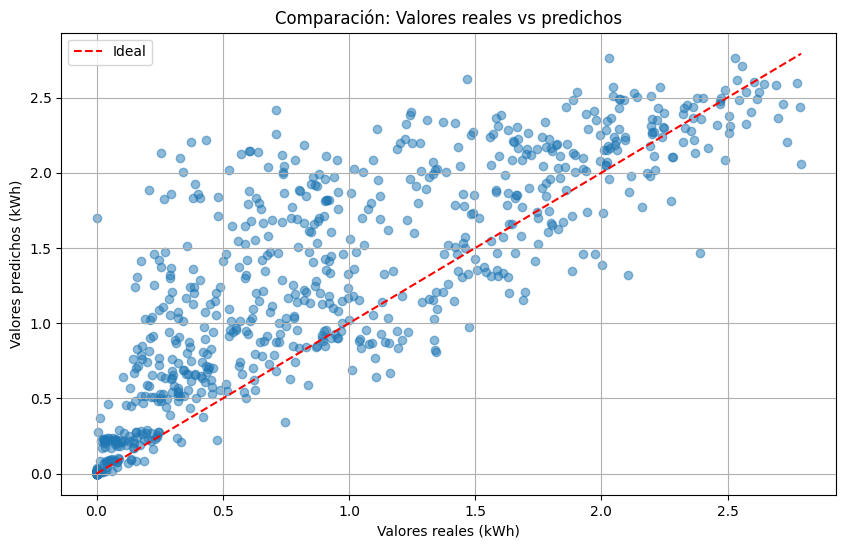

In [472]:
plt.figure(figsize=(10,6))
plt.scatter(gen_test_y, random_predictions, alpha=0.5)
plt.plot([gen_test_y.min(), gen_test_y.max()], [gen_test_y.min(), gen_test_y.max()], 'r--', label='Ideal')
plt.xlabel('Valores reales (kWh)')
plt.ylabel('Valores predichos (kWh)')
plt.title('Comparación: Valores reales vs predichos')
plt.legend()
plt.grid()
plt.show()

In [473]:
rf_params = {
    'n_estimators': [300, 100],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [3, 5],
    'max_features': [0.7],
    'max_depth': [10, 20]
}

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(estimator=forest_reg,
                           param_grid=rf_params,
                           cv=tcsv,
                           scoring='neg_mean_squared_error',
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(gen_x, gen_y)
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 300}


In [474]:
best_model = grid_search.best_estimator_
final_predictions = best_model.predict(gen_test_x)
final_mse = mean_squared_error(gen_test_y, final_predictions)
final_mae = mean_absolute_error(gen_test_y, final_predictions)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(gen_test_y, final_predictions)
print(f"RMSE: {final_rmse}")
print(f"MAE: {final_mae}")
print(f"R2: {final_r2}")

RMSE: 0.5366649709337452
MAE: 0.3639360734027405
R2: 0.518371076325399


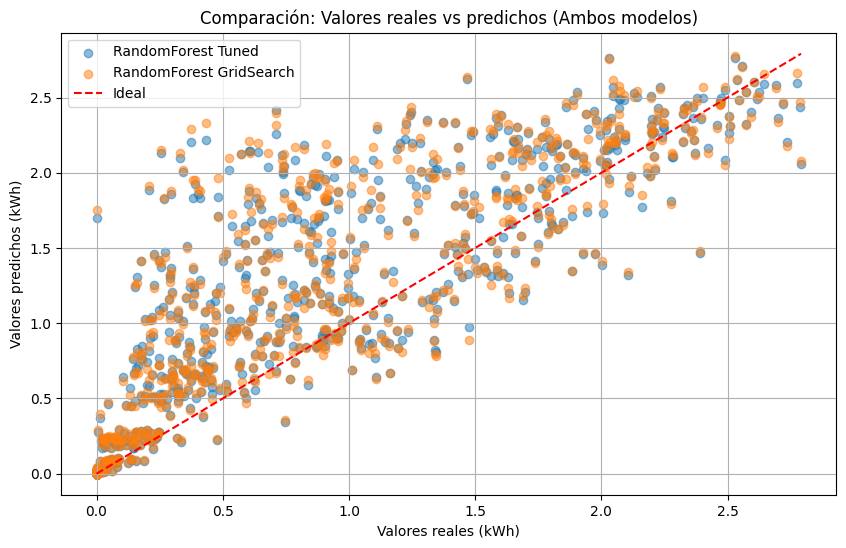

In [475]:
plt.figure(figsize=(10,6))
plt.scatter(gen_test_y, random_predictions, alpha=0.5, label='RandomForest Tuned')
plt.scatter(gen_test_y, final_predictions, alpha=0.5, label='RandomForest GridSearch')
plt.plot([gen_test_y.min(), gen_test_y.max()], [gen_test_y.min(), gen_test_y.max()], 'r--', label='Ideal')
plt.xlabel('Valores reales (kWh)')
plt.ylabel('Valores predichos (kWh)')
plt.title('Comparación: Valores reales vs predichos (Ambos modelos)')
plt.legend()
plt.grid()
plt.show()

## `XGBoost`

### Modelo básico sin tunear

In [476]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror',
    tree_method='hist',
    n_estimators=600,
    learning_rate=0.07,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    n_jobs=-1,
    random_state=42)
xgb.fit(gen_x, gen_y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [477]:
xgb_predictions = xgb.predict(gen_x)
xgb_mse = mean_squared_error(gen_y, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(gen_y, xgb_predictions)

print(f"RMSE: {xgb_rmse}")
print(f"MAE: {xgb_mae}")

RMSE: 0.039194578174859426
MAE: 0.026764767281201668


In [478]:
from sklearn.metrics import r2_score

y_pred = xgb.predict(gen_test_x)
xgb_test_mse = mean_squared_error(gen_test_y, y_pred)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_mae = mean_absolute_error(gen_test_y, y_pred)
xgb_test_r2 = r2_score(gen_test_y, y_pred)
print(f"Test RMSE: {xgb_test_rmse}")
print(f"Test MAE: {xgb_test_mae}")
print(f"Test R2: {xgb_test_r2}")

Test RMSE: 0.485089119546563
Test MAE: 0.3408812897633336
Test R2: 0.6064960200863883


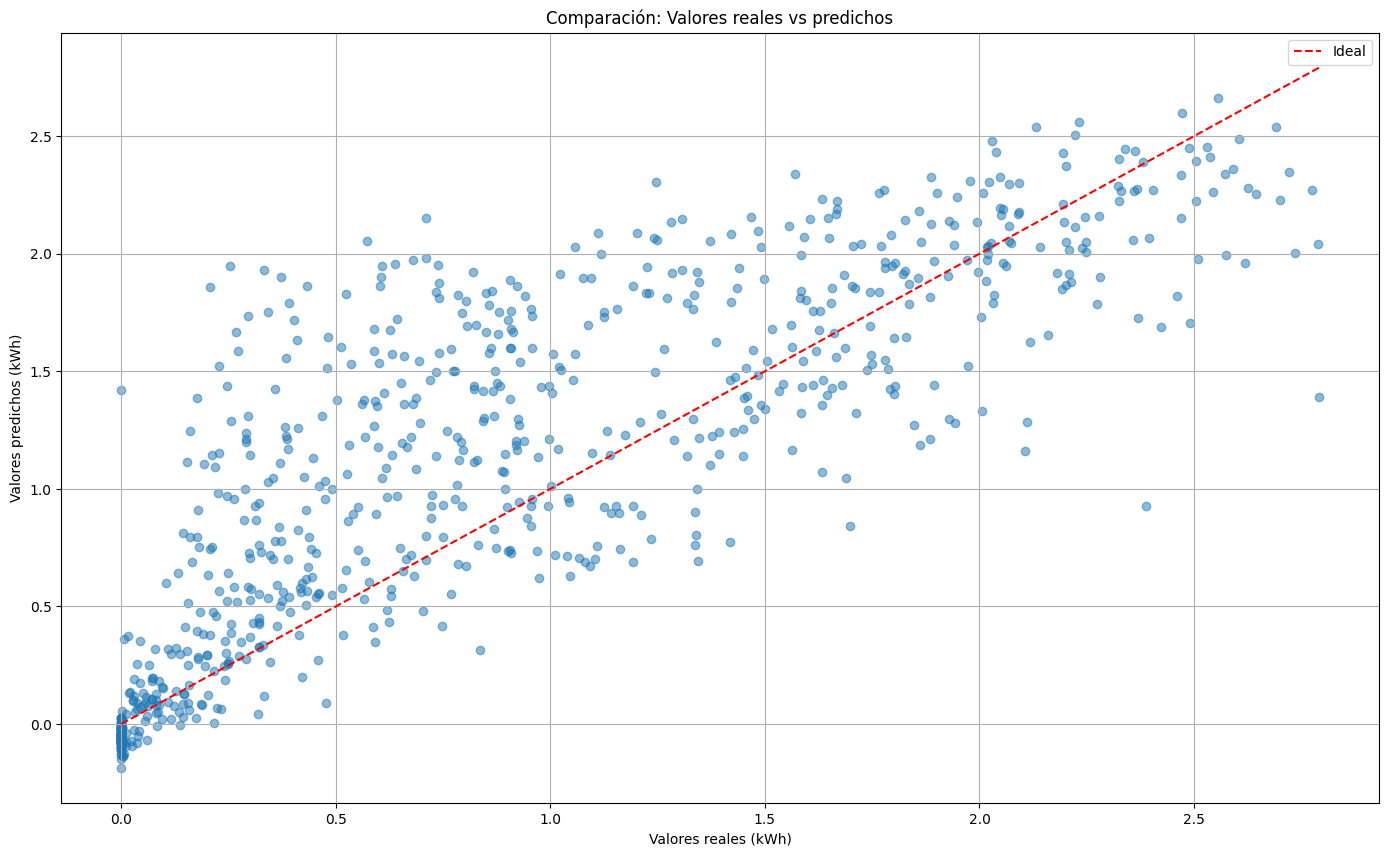

In [483]:
plt.figure(figsize=(17, 10))
plt.scatter(gen_test_y, y_pred, alpha=0.5)
plt.plot([gen_test_y.min(), gen_test_y.max()], [gen_test_y.min(), gen_test_y.max()], 'r--', label='Ideal')
plt.xlabel('Valores reales (kWh)')
plt.ylabel('Valores predichos (kWh)')
plt.title('Comparación: Valores reales vs predichos')
plt.legend()
plt.grid()
plt.show()

In [479]:
importances = xgb.feature_importances_
feature_names = gen_x.columns
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

HR: 0.2622
T2M: 0.0073
RH2M: 0.0064
ALLSKY_KT: 0.2368
ALLSKY_SFC_SW_DWN: 0.0208
PRECTOTCORR: 0.0161
WS10M: 0.0062
DOY: 0.0218
hour_sin: 0.1744
temp_irr: 0.0925
hum_irr: 0.0080
irr_div_temp: 0.0104
solar_potential: 0.0669
irradiance_to_angle: 0.0328
angle_radiation: 0.0250
clearsky_ratio: 0.0124


### Modelo tuneado

In [480]:
param_dist = {
    'n_estimators': [600, 900, 1200, 1500],
    'learning_rate': np.linspace(0.03, 0.12, 6),
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 8, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.5, 1, 2],
    'reg_alpha': [0, 0.1, 0.3, 0.7],
    'reg_lambda': [0.5, 1, 2, 5],
}

xgb = XGBRegressor(objective='reg:squarederror',
                   tree_method='hist', n_jobs=-1,
                   random_state=42)

xgb_rand = RandomizedSearchCV(estimator=xgb, 
                              param_distributions=param_dist, 
                              n_iter=50,
                              cv=tcsv,
                              scoring='neg_root_mean_squared_error',
                              verbose=2,
                              random_state=42,
                              n_jobs=-1)

xgb_rand.fit(gen_x, gen_y)
print("Best parameters found: ", xgb_rand.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.3, 'n_estimators': 900, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': np.float64(0.102), 'gamma': 0.5, 'colsample_bytree': 0.8}


In [481]:
xgb_rand_model = xgb_rand.best_estimator_

xgb_pred = xgb_rand_model.predict(gen_test_x)
xgb_test_mse = mean_squared_error(gen_test_y, xgb_pred)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_mae = mean_absolute_error(gen_test_y, xgb_pred)
xgb_test_r2 = r2_score(gen_test_y, xgb_pred)

print(f"Test RMSE: {xgb_test_rmse}")
print(f"Test MAE: {xgb_test_mae}")
print(f"Test R2: {xgb_test_r2}")

Test RMSE: 0.5196875292111681
Test MAE: 0.3554027980240371
Test R2: 0.5483618158482835


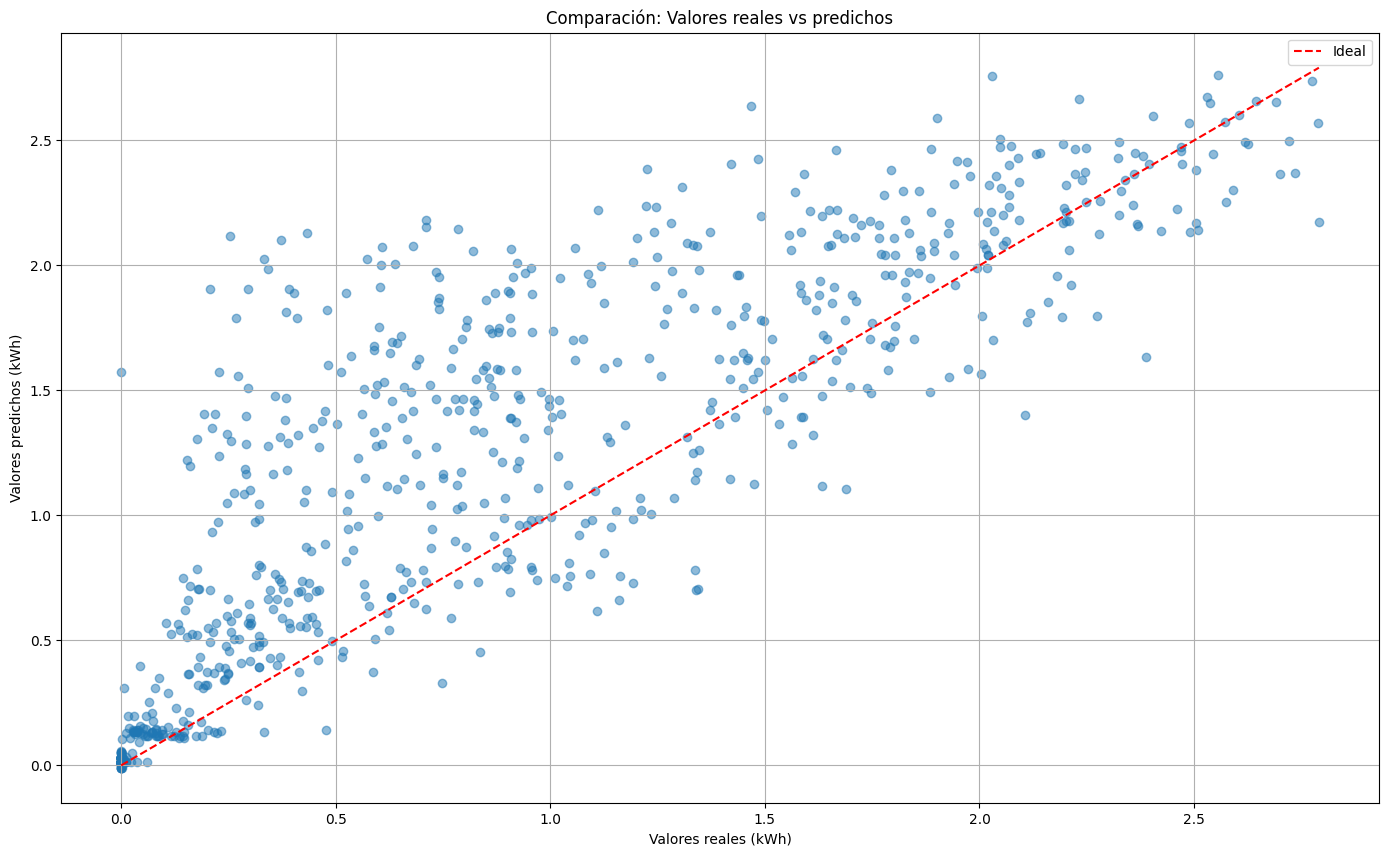

In [482]:
plt.figure(figsize=(17, 10))
plt.scatter(gen_test_y, xgb_pred, alpha=0.5)
plt.plot([gen_test_y.min(), gen_test_y.max()], [gen_test_y.min(), gen_test_y.max()], 'r--', label='Ideal')
plt.xlabel('Valores reales (kWh)')
plt.ylabel('Valores predichos (kWh)')
plt.title('Comparación: Valores reales vs predichos')
plt.legend()
plt.grid()
plt.show()